In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchaudio
from transformers import BertTokenizer
import torch.nn as nn
from torchinfo import summary

import cv2
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

objc[31225]: Class AVFFrameReceiver is implemented in both /Users/tt/miniforge3/envs/ds/lib/python3.8/site-packages/av/.dylibs/libavdevice.60.3.100.dylib (0x12da98760) and /Users/tt/miniforge3/envs/ds/lib/libavdevice.59.7.100.dylib (0x168cd4778). One of the two will be used. Which one is undefined.
objc[31225]: Class AVFAudioReceiver is implemented in both /Users/tt/miniforge3/envs/ds/lib/python3.8/site-packages/av/.dylibs/libavdevice.60.3.100.dylib (0x12da987b0) and /Users/tt/miniforge3/envs/ds/lib/libavdevice.59.7.100.dylib (0x168cd47c8). One of the two will be used. Which one is undefined.


In [2]:
# Total Classes
pd.read_csv('./MELD_Data/train.csv')['Emotion'].unique()

array(['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust',
       'anger'], dtype=object)

In [16]:
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [18]:
from DataLoader import MELD
train_loader = MELD('train', batch_size=4)
valid_loader = MELD('valid', batch_size=4)
test_loader = MELD('test', batch_size=4)

for batch in train_loader:
    videos, audios, texts, attention_masks, labels = batch
    videos = videos.permute(0, 2, 1, 3, 4)
    print(f"Video (B, F, C, H, W) : {videos.shape}")
    print(f"Audio (B, C, S) : {audios.shape}")
    print(f"Text  (B, L) : {texts.shape}")
    print(f"Label (B) : {labels.shape}")
    break

# Video (Batch, Frame, Channel, Height, Width)
# Audio (Batch, Channel, Sample) 
# Text  (Batch, tokenized Length)
# Label (Batch)


/Users/tt/miniforge3/envs/ds/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/tt/miniforge3/envs/ds/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/tt/miniforge3/envs/ds/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Video (B, F, C, H, W) : torch.Size([4, 3, 30, 224, 224])
Audio (B, C, S) : torch.Size([4, 1, 16000])
Text  (B, L) : torch.Size([4, 128])
Label (B) : torch.Size([4])


In [19]:
import matplotlib.pyplot as plt
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
df = pd.read_csv('./MELD_Data/train.csv')
emotions = {i : df['Emotion'].unique()[i] for i in range(len(df['Emotion'].unique()))}
emotions

{0: 'neutral',
 1: 'surprise',
 2: 'fear',
 3: 'sadness',
 4: 'joy',
 5: 'disgust',
 6: 'anger'}

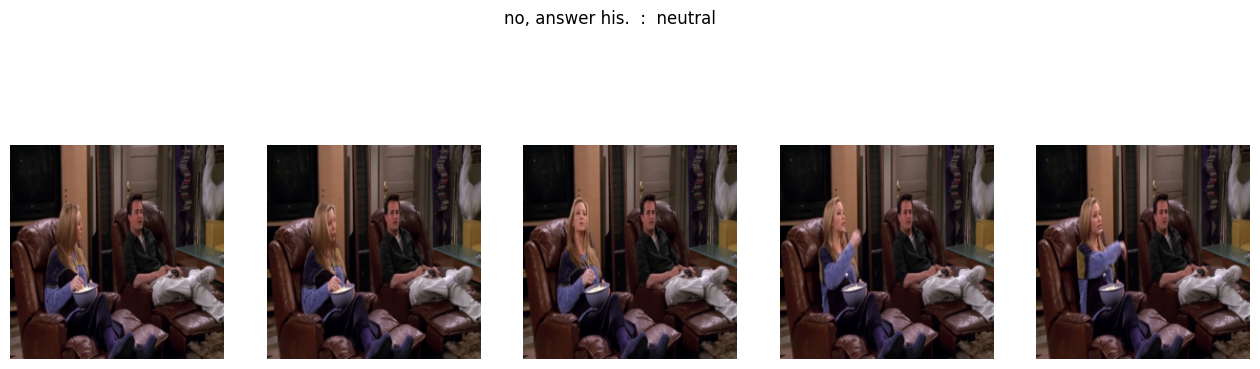

In [21]:
tmp = next(iter(train_loader))
plt.figure(figsize=(16, 5))
video = tmp[0][0]
for i in range(5):
    sentence = tokenizer.decode(tmp[2][0]).replace('[CLS]', '').replace('[SEP]', '').replace('[PAD]', '').strip(' ')
    emotion = emotions[tmp[4][0].item()]
    plt.suptitle(sentence + '  :  ' + emotion)
    plt.subplot(1, 5, i+1)
    plt.imshow(video[6*i].permute(1,2,0))
    plt.axis('off')

In [22]:
label2id = {label : i for i, label in emotions.items()}
id2label = emotions.copy()

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger'].


In [7]:
def contrastive_loss(v, a, t, mode, eps, dim):
    loss = 0
    if mode == 'modality':
        for i in range(dim):
            if i // 3 == 0:
                loss += (v @ a) * t
            else:
                loss += max(0, eps - ((v @ a) * t))
    if mode == 'utterance':
        for i in range(dim):
            if i % 3 == 0:
                loss += (v @ a) * t
            else:
                loss += max(0, eps - ((v @ a) * t))
    return loss

In [8]:
class MELDClassifier(nn.Module):
    def __init__(self, video_model, audio_model, text_model, out_dim):
        # Feature Extractor
        super().__init__()
        self.video_model = video_model
        self.audio_model = audio_model
        self.text_model = text_model
        # Disentanglement
        self.WdisUv = nn.Linear(768, 768)
        self.WdisUa = nn.Linear(768, 768)
        self.WdisUt = nn.Linear(768, 768)
        self.WdisMv = nn.Linear(768, 768)
        self.WdisMa = nn.Linear(768, 768)
        self.WdisMt = nn.Linear(768, 768)
        # Weight
        self.MLPv = nn.Linear(3*768, 1)
        self.MLPa = nn.Linear(3*768, 1)
        self.MLPt = nn.Linear(3*768, 1)
        # Classification
        self.clf = nn.Linear(768, out_dim)
        # Other loss
        self.utt_loss = 0
        self.mod_loss = 0
        

    def forward(self, v, a, t, attm):
        fv = None
        for i in range(0, 30, 6):
            if fv is None:
                fv = self.video_model(v[:, i, :, :, :])
            else:
                fv += self.video_model(v[:, i, :, :, :])
        print(a.shape)
        fa = self.audio_model(a)
        ft = self.text_model(t, attm)
        print(fa[0].shape)
        # Disentanglement wrt utterance
        fv_utter = self.WdisUv(fv)
        fa_utter = self.WdisUa(fa[0])
        ft_utter = self.WdisUt(ft)
        self.utt_loss = contrastive_loss(fv_utter, fa_utter, ft_utter, 'utterance', 0.5, len())
        # Disentanglement wrt modality
        fv_modal = self.WdisMv(fv)
        fa_modal = self.WdisMa(fa)
        ft_modal = self.WdisMt(ft)
        self.mod_loss = contrastive_loss(fv_utter, fa_utter, ft_utter, 'modality', 0.5, len())
        # Concatenation
        fv_concat = F.elu(torch.concat([fv, fv_utter, fv_modal]))
        fa_concat = F.elu(torch.concat([fa, fa_utter, fa_modal]))
        ft_concat = F.elu(torch.concat([ft, ft_utter, ft_modal]))
        # Weight to each vector
        wv = F.sigmoid(self.MLPv(fv_concat))
        wa = F.sigmoid(self.MLPa(fa_concat))
        wt = F.sigmoid(self.MLPt(ft_concat))
        # Summation
        h = wv*fv_concat + wa*fa_concat + wt*ft_concat
        h = self.clf(h)
        return h
        
        
        

In [199]:
import torchaudio.transforms as aT

def audio_to_melscale_fbank(audio, sample_rate=16000, n_mels=128):
    """
    Convert audio waveform to 128-dimensional melscale filter bank.

    Args:
    - audio (torch.Tensor): Tensor of shape (1, 16000) representing the audio waveform.
    - sample_rate (int): The sample rate of the audio data.
    - n_mels (int): The number of mel filter banks. Default is 128.

    Returns:
    - torch.Tensor: The mel filter bank representation of the audio.
    """
    # Define the MelSpectrogram transformation
    mel_spectrogram_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=400,            # The size of FFT, can be adjusted as needed
        hop_length=160,       # The hop length, can be adjusted as needed
        n_mels=n_mels
    )
    
    # Apply the transformation
    mel_spectrogram = mel_spectrogram_transform(audio)
    
    # Convert to log scale (optional, but common)
    log_mel_spectrogram = torch.log(mel_spectrogram + 1e-9)
    
    return log_mel_spectrogram.squeeze(1)


In [209]:
import os, sys
sys.path.append(os.path.join('./ast/src/models'))
from ast_models import ASTModel
import torch

# audioset input sequence length is 1024
pretrained_mdl_path = './Pretrained/audioset_10_10_0.4593.pth'
# get the frequency and time stride of the pretrained model from its name
fstride, tstride = int(pretrained_mdl_path.split('/')[-1].split('_')[1]), int(pretrained_mdl_path.split('/')[-1].split('_')[2].split('.')[0])
# The input of audioset pretrained model is 1024 frames.
input_tdim = 1024

# initialize an AST model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sd = torch.load(pretrained_mdl_path, map_location=device)
audio_model = ASTModel(input_tdim=input_tdim, fstride=fstride, tstride=tstride)
audio_model = torch.nn.DataParallel(audio_model)
audio_model.load_state_dict(sd, strict=False)
audio_model.module.mlp_head[1] = nn.Identity()

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212


In [210]:
audio_model

DataParallel(
  (module): ASTModel(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dro

In [9]:
import torch.nn.functional as F
from transformers import DebertaV2Model

class AngleSDETextEmbeddingModel(nn.Module):
    def __init__(self):
        super(AngleSDETextEmbeddingModel, self).__init__()
        self.deberta = DebertaV2Model.from_pretrained('microsoft/deberta-v3-base')
        self.sde_layer = nn.Linear(768, 768)  # SDE 방식 추가
        self.angle_weight = nn.Parameter(torch.Tensor(768, 768))  # AnglE 방식 수정
        nn.init.uniform_(self.angle_weight)
        
    def angle_optimization(self, embeddings):
        norm = embeddings.norm(p=2, dim=1, keepdim=True)
        normalized_embeddings = embeddings / norm
        angles = torch.mm(normalized_embeddings, self.angle_weight)
        return angles

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]  # Use the representation of the [CLS] token
        
        # Apply SDE
        sde_output = self.sde_layer(pooled_output)
        sde_output = F.relu(sde_output)
        
        # Apply AnglE
        angle_output = self.angle_optimization(sde_output)
        
        return angle_output

audio_model = AngleSDETextEmbeddingModel()


/Users/tt/miniforge3/envs/ds/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClass

In [40]:
def contrastive_loss2(v, t, mode, eps, dim):
    loss = 0
    if mode == 'modality':
        for i in range(dim):
            if i // 2 == 0:
                loss += v @ t.T
            else:
                loss += eps - (v @ t.T)
    if mode == 'utterance':
        for i in range(dim):
            if i % 2 == 0:
                loss += v @ t.T
            else:
                loss += eps - v @ t.T
    return loss

In [41]:
class MELDClassifier2(nn.Module):
    def __init__(self, video_model, text_model, out_dim):
        # Feature Extractor
        super().__init__()
        self.video_model = video_model
        self.text_model = text_model
        # Disentanglement
        self.WdisUv = nn.Linear(400, 400)
        self.WdisUt = nn.Linear(768, 400)
        self.WdisMv = nn.Linear(400, 400)
        self.WdisMt = nn.Linear(768, 400)
        # Weight
        self.MLPv = nn.Linear(400, 1)
        self.MLPt = nn.Linear(400, 1)
        # Classification
        self.clf = nn.Linear(400, out_dim)
        # Other loss
        self.utt_loss = 0
        self.mod_loss = 0
        

    def forward(self, v, t, attm):
        with torch.no_grad():
            self.video_model.eval()
            self.text_model.eval()
            fv = self.video_model(v)
            ft = self.text_model(t, attm)
        self.video_model.train()
        self.text_model.eval()
        # Disentanglement wrt utterance
        fv_utter = self.WdisUv(fv)
        ft_utter = self.WdisUt(ft)
        self.utt_loss = contrastive_loss2(fv_utter, ft_utter, 'utterance', 0.5, 400)
        # Disentanglement wrt modality
        fv_modal = self.WdisMv(fv)
        ft_modal = self.WdisMt(ft)
        self.mod_loss = contrastive_loss2(fv_modal, ft_modal, 'modality', 0.5, 400)
        # Concatenation
        fv_concat = F.elu(torch.concat([fv, fv_utter, fv_modal]))
        ft_concat = F.elu(torch.concat([ft, ft_utter, ft_modal]))
        # Weight to each vector
        wv = F.sigmoid(self.MLPv(fv_concat))
        wt = F.sigmoid(self.MLPt(ft_concat))
        # Summation
        h = wv*fv_concat + wt*ft_concat
        h = self.clf(h)
        return h
        
        
        

In [4]:
from torchvision.models.video import swin3d_b
from transformers import BertTokenizer

video_model = swin3d_b(weights='KINETICS400_IMAGENET22K_V1')
video_model.heads = nn.Identity()

#text_model = AngleSDETextEmbeddingModel()

In [5]:
video_model

SwinTransformer3d(
  (patch_embed): PatchEmbed3d(
    (proj): Conv3d(3, 128, kernel_size=(2, 4, 4), stride=(2, 4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (features): Sequential(
    (0): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention3d(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
      

In [43]:
model = MELDClassifier2(video_model=video_model, 
                        text_model=text_model, 
                        out_dim=7).to('mps')
loss_fn = nn.CrossEntropyLoss().to('mps')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
for epoch in range(10):
    loss_tmp = 0
    acc_tmp = 0
    for video, _, text, attm, label in tqdm(train_loader):
        optimizer.zero_grad()
        video = video.permute(0, 2, 1, 3, 4)
        yhat = model(video.to('mps'), text.to('mps'), attm.to('mps'))
        loss = loss_fn(yhat, label)
        loss.backward()
        optimizer.step()
        loss_tmp += loss.item()     
        acc_tmp += (yhat.argmax(1) == label).type(torch.float).sum().item()
    print(f"Epoch {epoch} : Accuracy {acc_tmp:.2f}, Loss {loss_tmp:.2f}")


  0%|          | 0/2498 [00:00<?, ?it/s]

: 

In [174]:
from torchaudio.pipelines import HUBERT_BASE
audio_model = HUBERT_BASE.get_model()

In [206]:
import torchaudio.transforms as transforms
def train_loop(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_func,
    optimizer: torch.optim, 
    device: str,
    transform: transforms = None,
    hide_process: bool = False):
    """Train model using device."""
    model.train()
    loss_tmp = 0
    acc_tmp = 0
    for video, audio, text, attmask, label in tqdm(data_loader, disable=hide_process):
        optimizer.zero_grad()
        audio = audio_to_melscale_fbank(audio)
        yhat = model(video, audio, text, attmask)
        celoss = loss_func(yhat, label)
        uttloss = model.utt_loss
        modloss = model.mod_loss
        loss = celoss + uttloss + modloss
        loss.backward()
        optimizer.step()
        loss_tmp += loss.item()     
        acc_tmp += (yhat.argmax(1) == label).type(torch.float).sum().item()
        
    loss_tmp /= len(data_loader)
    acc_tmp /= len(data_loader.dataset)
    return acc_tmp, loss_tmp

In [207]:
model = MELDClassifier(video_model, audio_model, text_model, 7)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters())
for epoch in range(5):
    accuracy, loss = train_loop(model, train_loader, loss_fn, optim, device='mps')

  0%|          | 0/2498 [00:02<?, ?it/s]

torch.Size([4, 128, 101])


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│   2 loss_fn = nn.CrossEntropyLoss()                                                              │
│   3 optim = torch.optim.AdamW(model.parameters())                                                │
│   4 for epoch in range(5):                                                                       │
│ ❱ 5 │   accuracy, loss = train_loop(model, train_loader, loss_fn, optim, device='mps')           │
│   6                                                                                              │
│                                                                                                  │
│ in train_loop:18                                                                                 │
│                                                                                                  │
│   15 │   for video, audio, text, attmask, label in tqdm(data_loader, disable=hide_process):      │
│   16 │   │   optimizer.zero_grad()                                                               │
│   17 │   │   audio = audio_to_melscale_fbank(audio)                                              │
│ ❱ 18 │   │   yhat = model(video, audio, text, attmask)                                           │
│   19 │   │   celoss = loss_func(yhat, label)                                                     │
│   20 │   │   uttloss = model.utt_loss                                                            │
│   21 │   │   modloss = model.mod_loss                                                            │
│                                                                                                  │
│ /Users/tt/miniforge3/envs/ds/lib/python3.8/site-packages/torch/nn/modules/module.py:1532 in      │
│ _wrapped_call_impl                                                                               │
│                                                                                                  │
│   1529 │   │   if self._compiled_call_impl is not None:                                          │
│   1530 │   │   │   return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]        │
│   1531 │   │   else:                                                                             │
│ ❱ 1532 │   │   │   return self._call_impl(*args, **kwargs)                                       │
│   1533 │                                                                                         │
│   1534 │   def _call_impl(self, *args, **kwargs):                                                │
│   1535 │   │   forward_call = (self._slow_forward if torch._C._get_tracing_state() else self.fo  │
│                                                                                                  │
│ /Users/tt/miniforge3/envs/ds/lib/python3.8/site-packages/torch/nn/modules/module.py:1541 in      │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1538 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1539 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1540 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1541 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1542 │   │                                                                                     │
│   1543 │   │   try:                                                                              │
│   1544 │   │   │   result = None                           